In [ ]:
import pandas as pd #Analysis
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis
from scipy.stats import norm #Analysis
from sklearn.preprocessing import StandardScaler #Analysis
from scipy import stats #Analysis
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
from collections import defaultdict

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import tensorflow as tf


## 1. Exploration Data Analysis

### 1.1. Understanding of the Data


First we will import Train data and Test data. The sizes of the two data are as follows:

It was data from https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com and crawled reviews from online pharmaceutical review sites.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/gdrive/My Drive/Drugs/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("/content/gdrive/My Drive/Drugs/drugsComTest_raw.csv", parse_dates=["date"])

In [ ]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [ ]:
df_train.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,2017-03-07,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,2015-03-14,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,2016-08-09,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1


These are additional explanations for variables.

- drugName (categorical): name of drug
- condition (categorical): name of condition
- review (text): patient review
- rating (numerical): 10 star patient rating
- date (date): date of review entry
- usefulCount (numerical): number of users who found review useful

The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

### 1.2. Understanding of the Data

In [ ]:
print("Unique value counts of UniqueID in train : " ,len(set(df_train['uniqueID'].values)))
print("Length of train : " ,df_train.shape[0])

Unique value counts of UniqueID in train :  161297
Length of train :  161297


DrugName is closely related to condition, so we have analyzed them together. The unique values of the two variables are 3671 and 917, respectively, and there are about 4 drugs for each condition. Let's go ahead and visualize this in more detail.

In [ ]:
df_all = pd.concat([df_train,df_test])

Text(0.5, 1.0, 'The number of drugs per condition (top 20).')

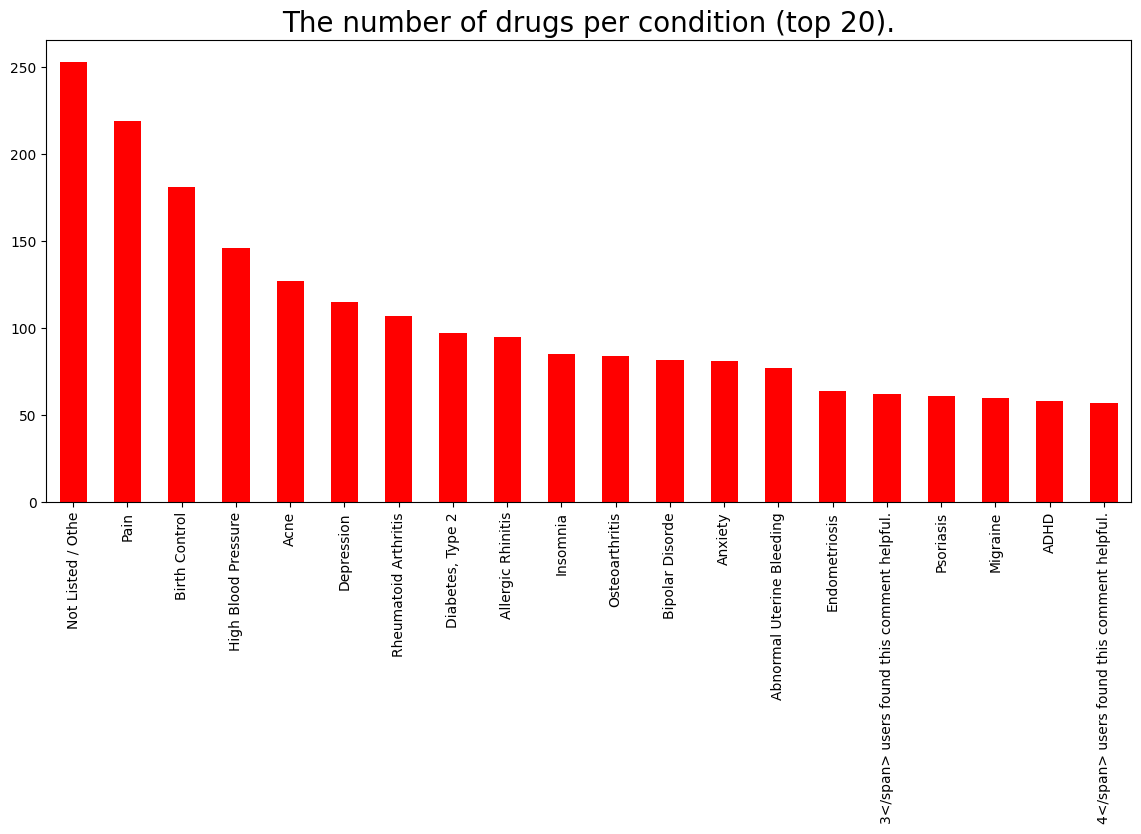

In [ ]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="red")
plt.xlabel("", fontsize = 22)
plt.ylabel("", fontsize = 22)
plt.title("The number of drugs per condition (top 20).", fontsize = 20)

From the image data above, it is evident that each of the top eight conditions has approximately 100 drugs available. However, it's worth mentioning that there appears to be an anomaly in the data: the text "3</span> users found this comment helpful" is included within the condition data, likely due to a mistake during the data extraction process. This issue has been further investigated for a more detailed understanding.

In [ ]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,2015-12-12,3



It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well. We will remove these data in the future preprocessing.

The following are the low 20 conditions of 'drugs per condition'. As you can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product. Therefore, we will analyze only the conditions that have at least 2 drugs per condition.

Text(0.5, 1.0, 'The number of drugs per condition (bottom 15).')

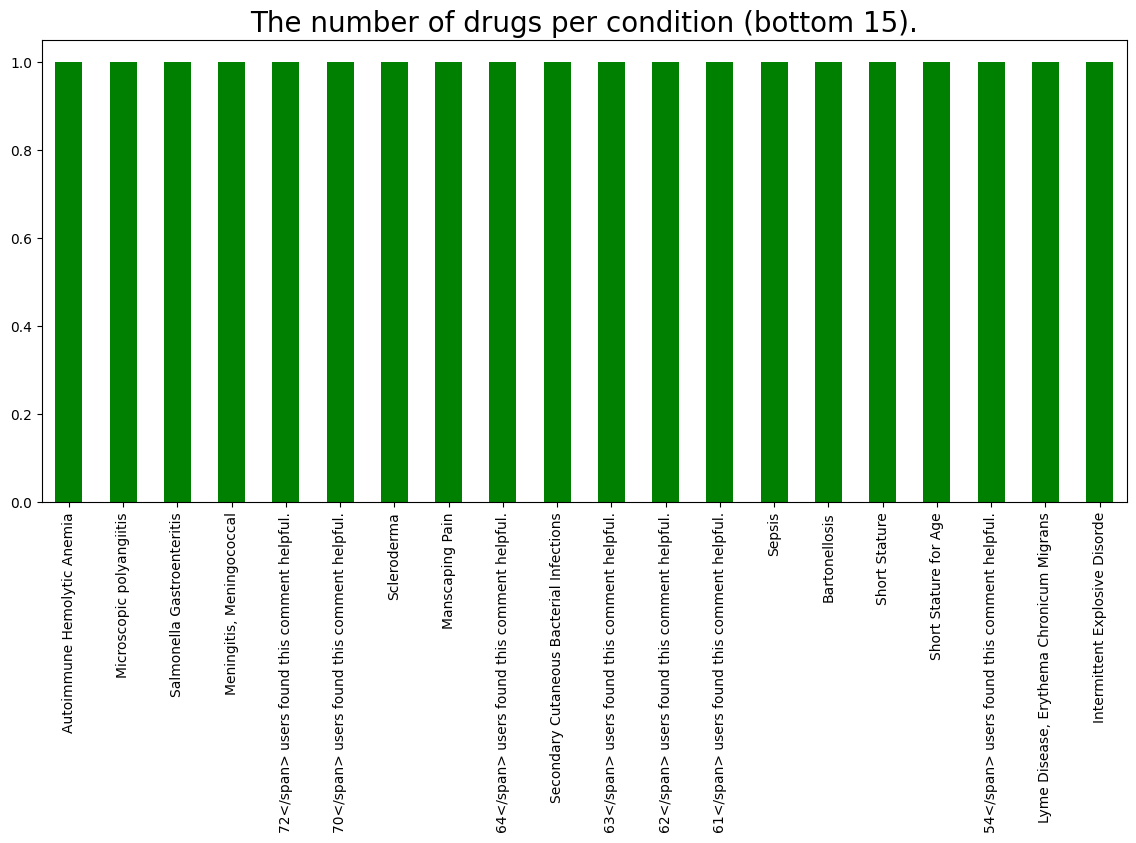

In [ ]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 22)
plt.ylabel("", fontsize = 22)
plt.title("The number of drugs per condition (bottom 15).", fontsize = 20)

Next, let's have a look at the review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH. In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [ ]:
df_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We will pass the revioews through thorough text processing to remove these unwanted parts

Next up, it's Word Cloud.

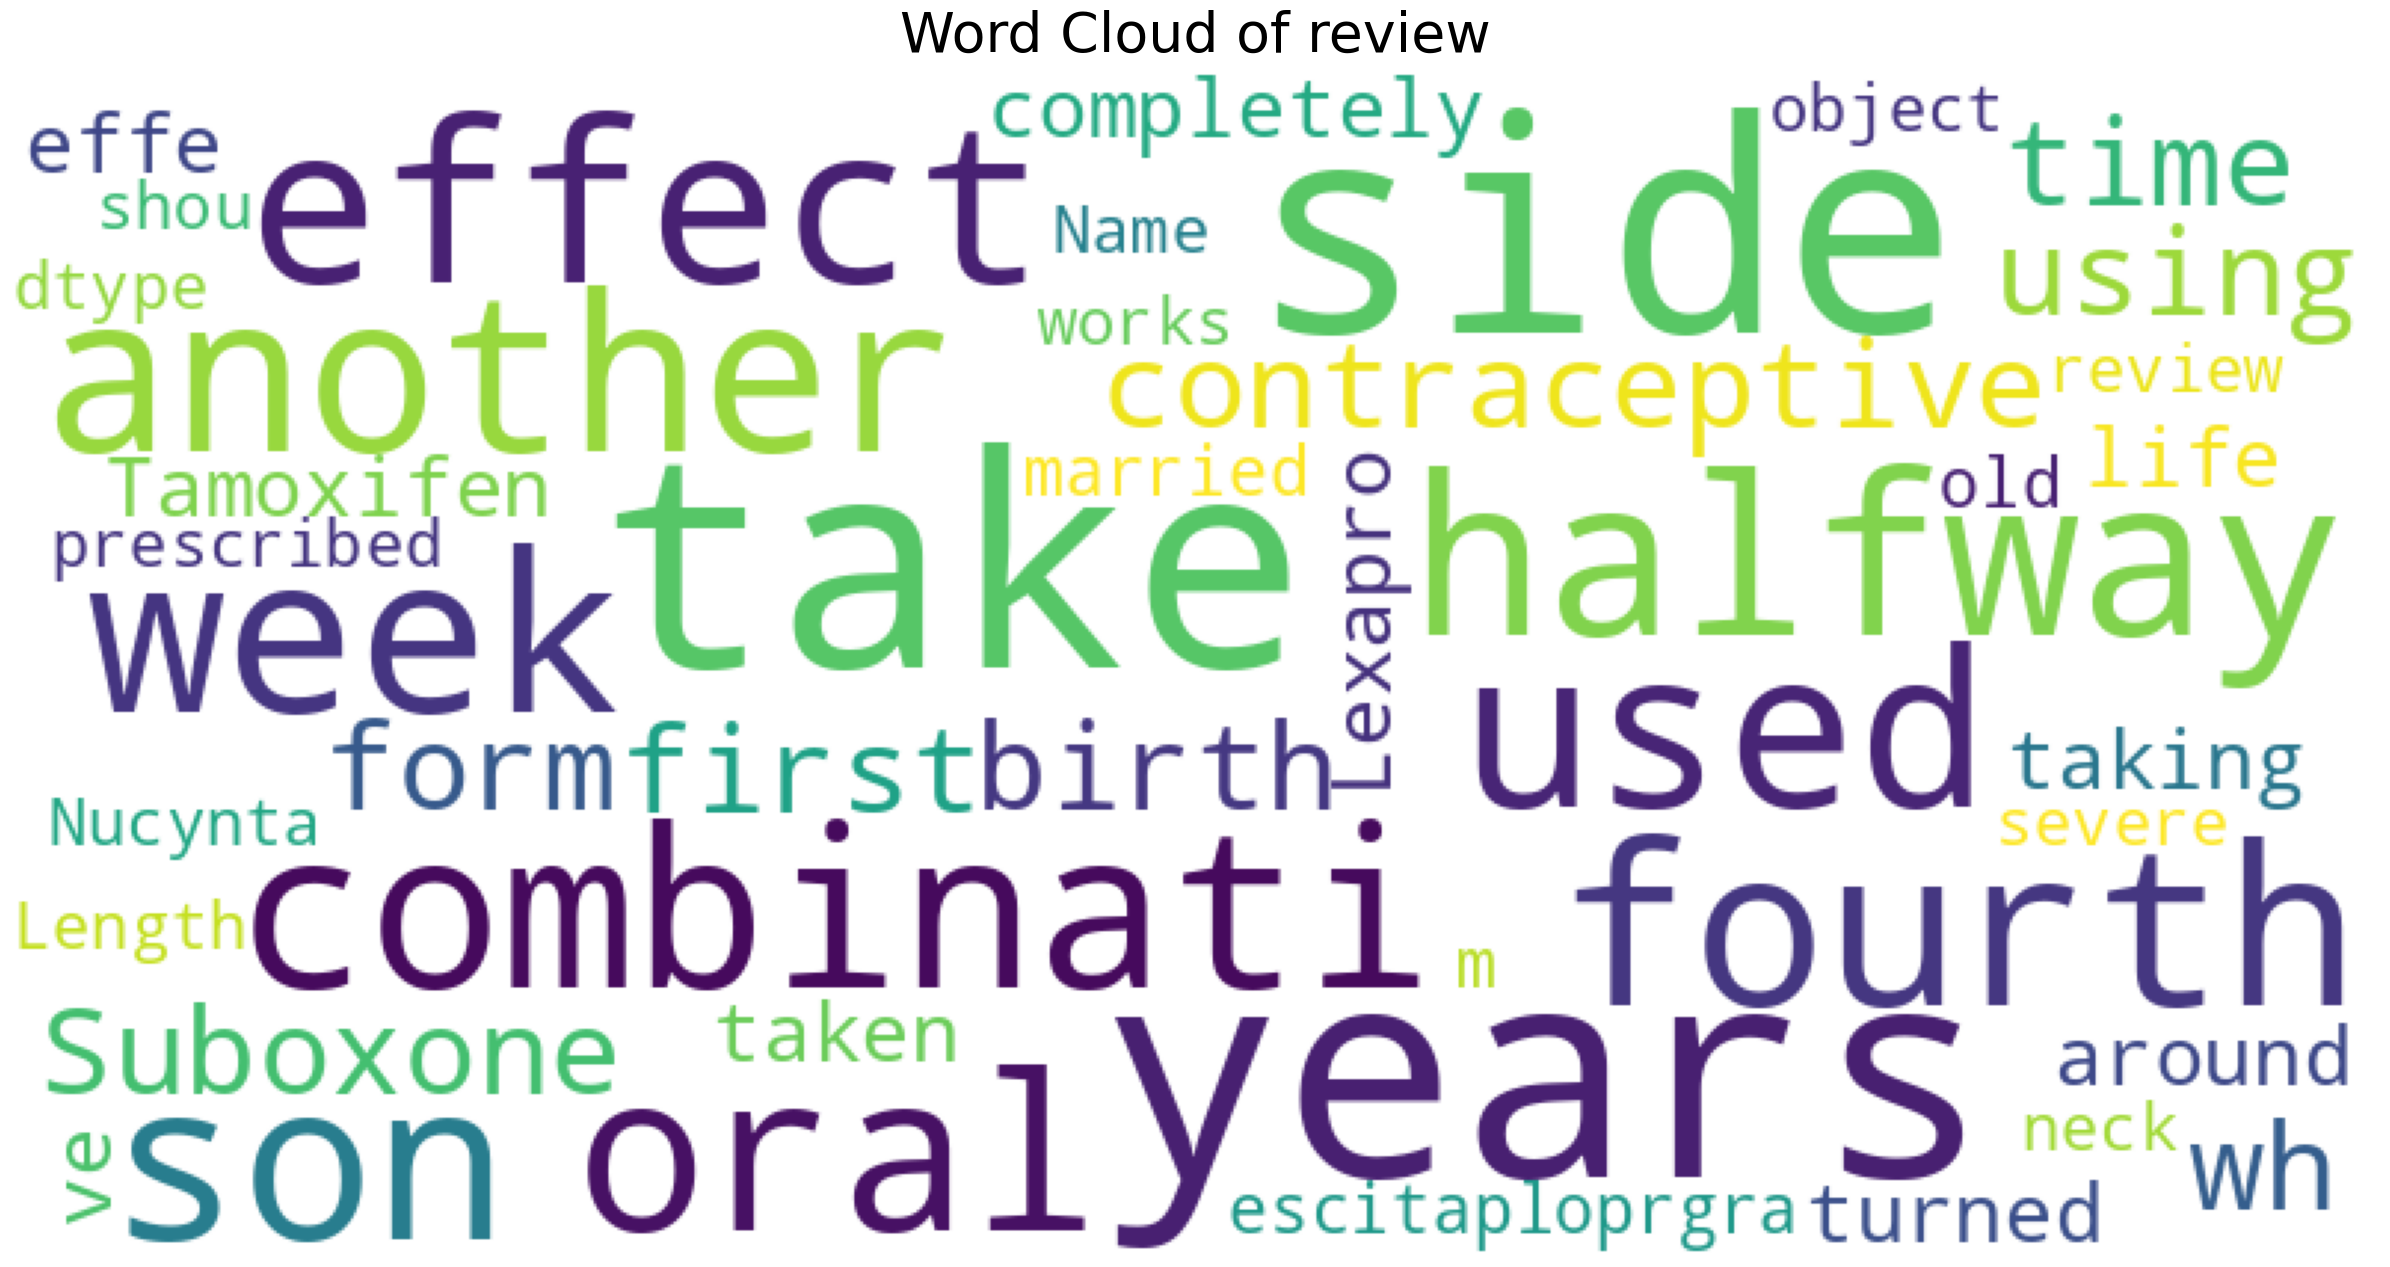

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def display_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    other_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(other_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

display_wordcloud(df_all["review"], title="Word Cloud of review")

Next, we will classify ratings 1 ~ 5 as negative, and 6 ~ 10 as positive

In [ ]:
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

Next, we will look for relationship between rating and weather. First of all, we will count the number of ratings.

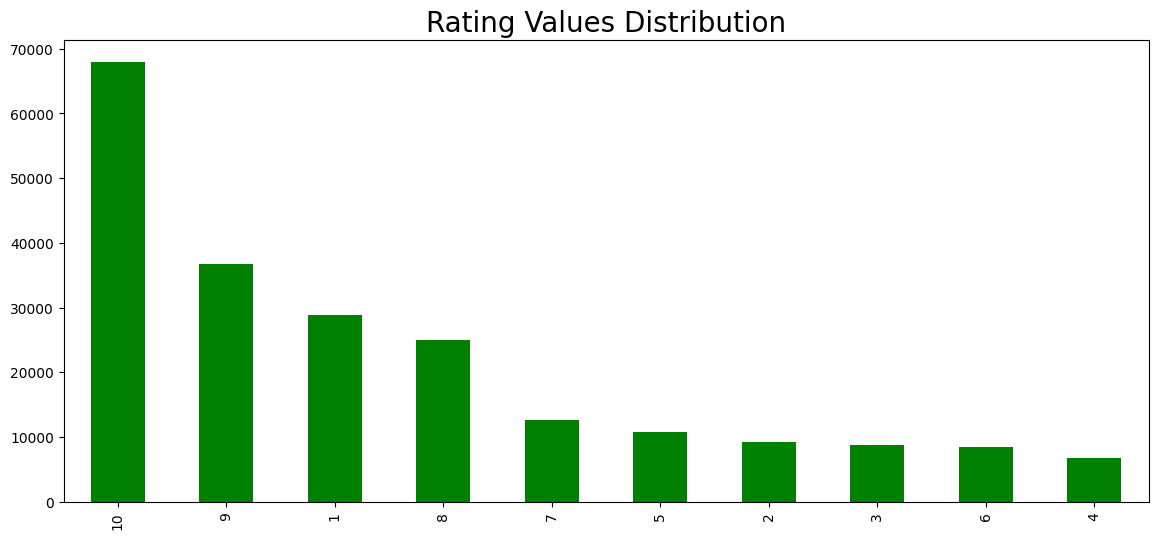

In [ ]:
import matplotlib.pyplot as plt

rating_counts = df_all['rating'].value_counts().sort_values(ascending=False)

rating_counts.plot(kind='bar', figsize=(14, 6), fontsize=10, color='green')

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.title('Rating Values Distribution', fontsize=20)
plt.show()

Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we can see that the percentage of positives is higher than negative, and people's reactions are extreme.

Next, we will check the number of reviews and percentage of ratings according to weather.

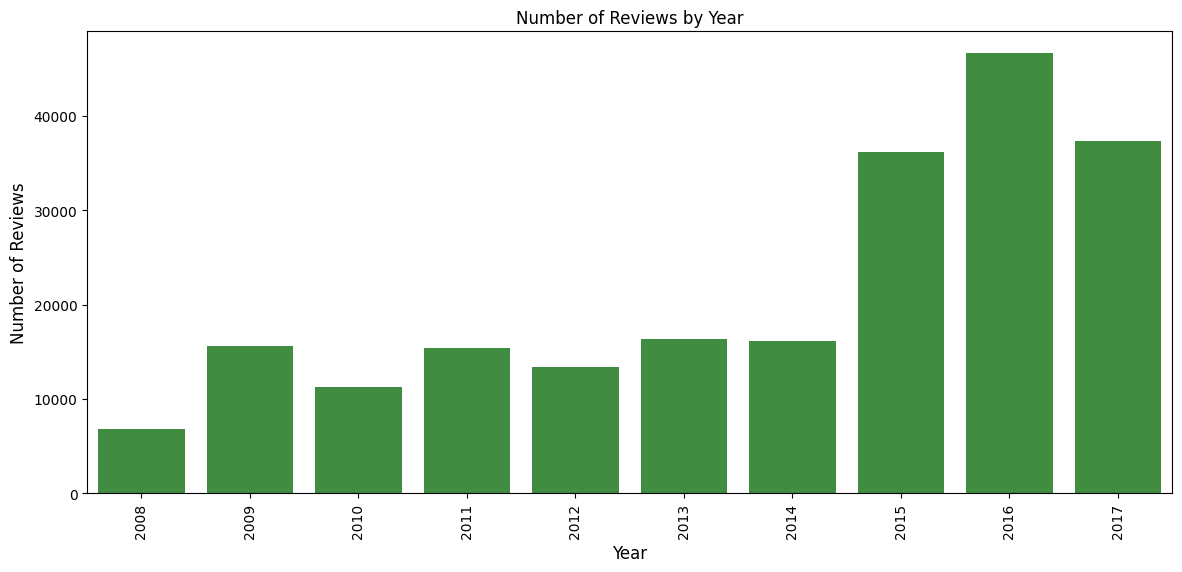

In [ ]:
import seaborn as sns

review_counts_by_year = df_all['date'].dt.year.value_counts().sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(x=review_counts_by_year.index, y=review_counts_by_year.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.title("Number of Reviews by Year")

# Display the plot
plt.show()

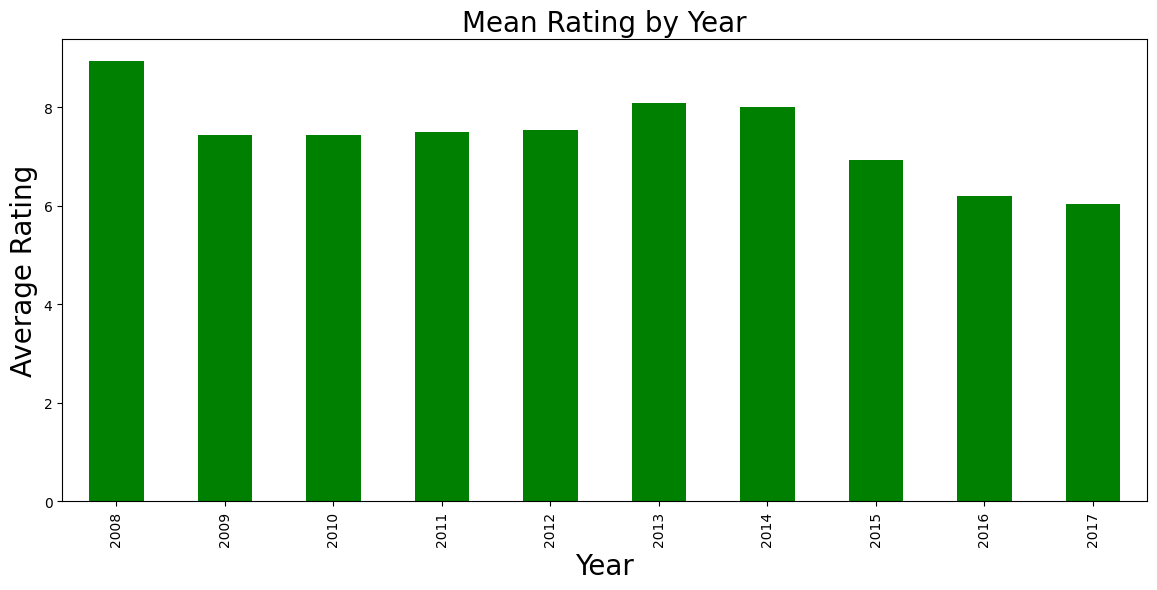

In [ ]:
df_all['year'] = df_all['date'].dt.year

average_rating_by_year = df_all.groupby('year')['rating'].mean()
average_rating_by_year.plot(kind="bar", figsize=(14, 6), fontsize=10, color="green")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Average Rating', fontsize=20)
plt.title("Mean Rating by Year", fontsize=20)

plt.show()

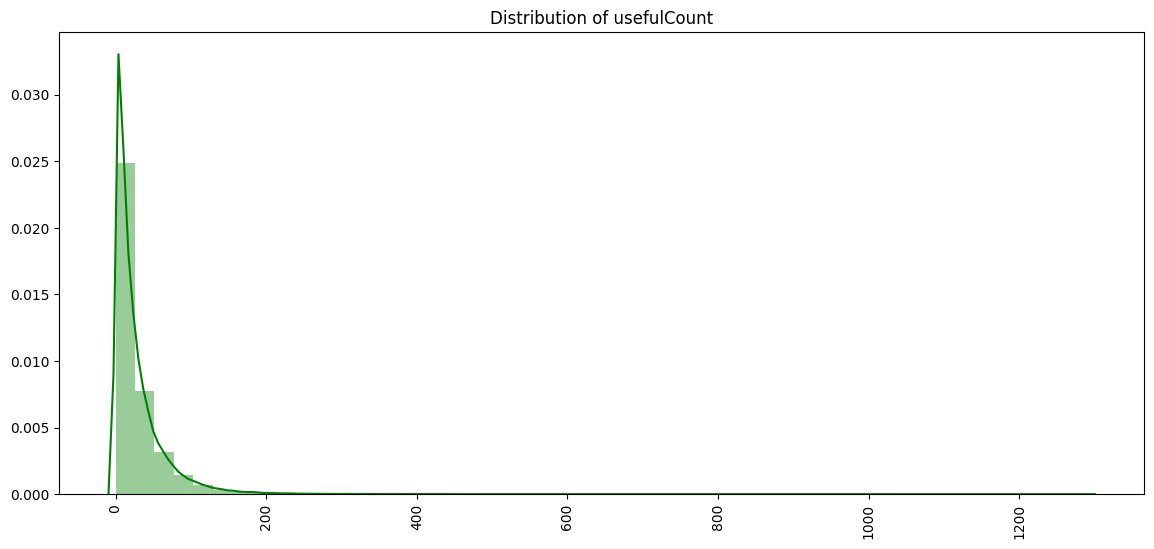

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["usefulCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [ ]:
df_all["usefulCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

The usefulCount distribution shows a significant range with a maximum difference of 1291 and a large standard deviation of 36. This variation is likely due to more popular drugs receiving higher review counts, regardless of the content quality. To counter this in our modeling, we will normalize usefulCount by conditions to adjust for disparities in drug popularity and reader engagement.

### 1.3 Missing Values

In [ ]:
missing_values_count = df_all.isnull().sum()
missing_values_count = missing_values_count.sort_values(ascending=False)

# Print the number of missing values
print("Number of Missing Values by Column:")
print("-----------------------------------")
print(missing_values_count)

Number of Missing Values by Column:
-----------------------------------
condition      1194
uniqueID          0
drugName          0
review            0
rating            0
date              0
usefulCount       0
year              0
dtype: int64


In [ ]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579760349292998


We will delete because the percentage is lower than 1%.

### 2.1. Missing Values Removal

In [ ]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

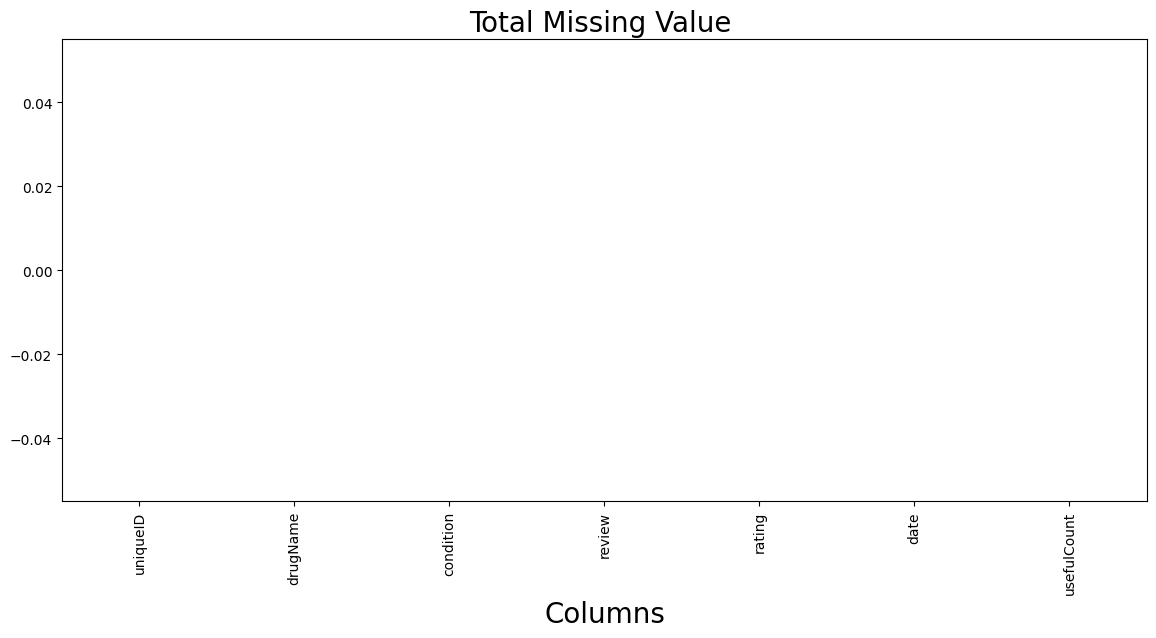

In [ ]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

### 2.2 Condition Preprocessing

We will delete the sentences with the form above.

In [ ]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [ ]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

Next, we will delete conditions with only one drug.

In [ ]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(10)

,condition,drugName
826,Somat,1
827,Somatoform Pain Disorde,1
828,Multiple Endocrine Adenomas,1
829,Mononucleosis,1
830,Sporotrichosis,1
831,Mixed Connective Tissue Disease,1
832,Steroid Responsive Inflammatory Conditions,1
833,Microscopic polyangiitis,1
834,Corneal Ulce,1
835,Esophageal Spasm,1


In [ ]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0              Wound Cleansing
1            Aggressive Behavi
2     Yellow Fever Prophylaxis
3         Tuberculosis, Active
4           Hyperbilirubinemia
5                Hydrocephalus
6                Hypercalcemia
7         Gestational Diabetes
8            Ectopic Pregnancy
9    unctional Gastric Disorde
Name: condition, dtype: object

In [ ]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 2.3 Review Preprocessing

In [ ]:
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- \r\n : we need to convert html grammer
- ... , &#039; : deal with not alphabet

In [ ]:
stops = set(stopwords.words('english'))

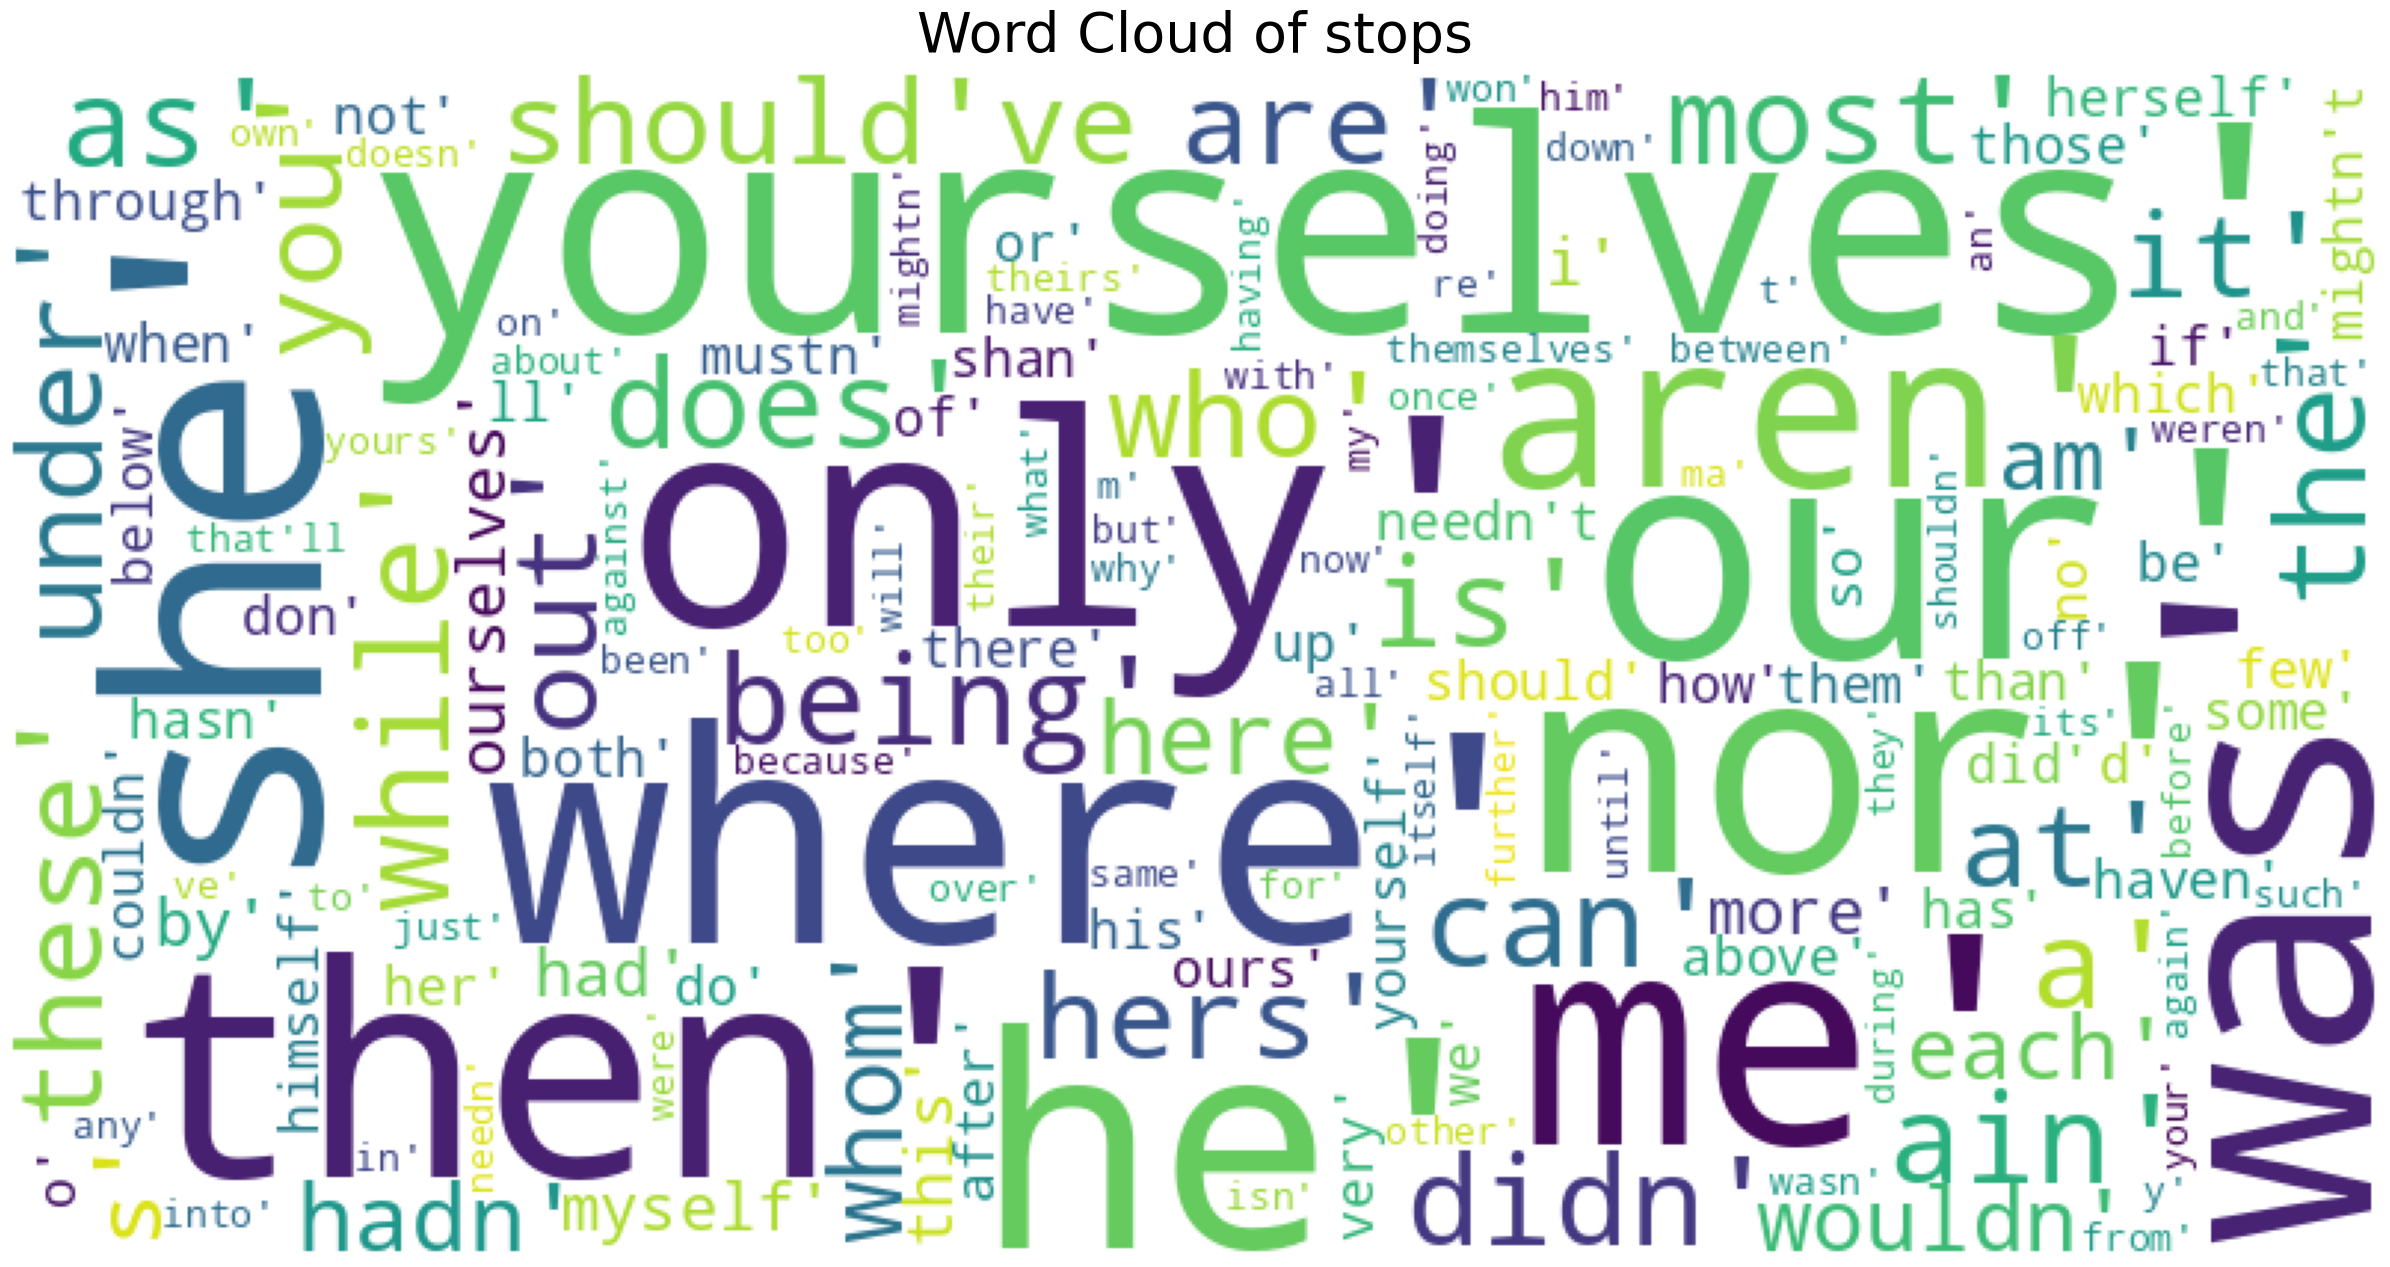

In [ ]:
 display_wordcloud(stops, title="Word Cloud of stops")

First, let's see what words are used as stopwords. There are many words that include not, like needn't. These words are key parts of emotional analysis, so we will remove them from stopwords.

In [ ]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [ ]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [ ]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: user 2min 18s, sys: 312 ms, total: 2min 19s
Wall time: 2min 19s


## 3. Model Building

### 3.1. Deep Learning Model Using N-gram

In [ ]:
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [ ]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2,
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [ ]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [ ]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.transform(df_test['review_clean'])  # Use transform here

CPU times: user 22.8 s, sys: 1 s, total: 23.8 s
Wall time: 24 s
CPU times: user 3.01 s, sys: 5.97 ms, total: 3.01 s
Wall time: 3.02 s


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 0. Package
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. Dataset
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               4000200   
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               60300     
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                       

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def csr_to_sparse_tensor(csr):
    coo = csr.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    sparse_tensor = tf.sparse.SparseTensor(indices, coo.data.astype(np.float32), coo.shape)
    # Reorder the sparse tensor
    ordered_sparse_tensor = tf.sparse.reorder(sparse_tensor)
    return ordered_sparse_tensor



In [ ]:
# Convert training data to SparseTensor
train_data_sparse = csr_to_sparse_tensor(train_data_features)

if isinstance(y_test, pd.Series):
    y_test = y_test.values

y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

if isinstance(y_train, pd.Series):
    y_train = y_train.values

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)


# Train the model
hist = model.fit(train_data_sparse, y_train_tensor, epochs=10, batch_size=64)

# Convert test data features to SparseTensor
test_data_sparse = csr_to_sparse_tensor(test_data_features)

# Ensure labels are in tensor format
if isinstance(y_test, pd.Series):
    y_test = y_test.values

y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


Epoch 1/10
2220/2220 [==============================] - 37s 14ms/step - loss: 0.5815 - accuracy: 0.7152
Epoch 2/10
2220/2220 [==============================] - 18s 8ms/step - loss: 0.4995 - accuracy: 0.7583
Epoch 3/10
2220/2220 [==============================] - 17s 8ms/step - loss: 0.4621 - accuracy: 0.7757
Epoch 4/10
2220/2220 [==============================] - 17s 8ms/step - loss: 0.4415 - accuracy: 0.7850
Epoch 5/10
2220/2220 [==============================] - 17s 7ms/step - loss: 0.4285 - accuracy: 0.7899
Epoch 6/10
2220/2220 [==============================] - 17s 8ms/step - loss: 0.4183 - accuracy: 0.7947
Epoch 7/10
2220/2220 [==============================] - 17s 7ms/step - loss: 0.4121 - accuracy: 0.7971
Epoch 8/10
2220/2220 [==============================] - 16s 7ms/step - loss: 0.4049 - accuracy: 0.8004
Epoch 9/10
2220/2220 [==============================] - 16s 7ms/step - loss: 0.3999 - accuracy: 0.8025
Epoch 10/10
2220/2220 [==============================] - 16s 7ms/step - 

In [ ]:
# Evaluate the model
loss_and_metrics = model.evaluate(test_data_sparse, y_test_tensor, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

2187/2187 [==============================] - 13s 6ms/step - loss: 0.5335 - accuracy: 0.7508
loss_and_metrics : [0.533510148525238, 0.7507930994033813]


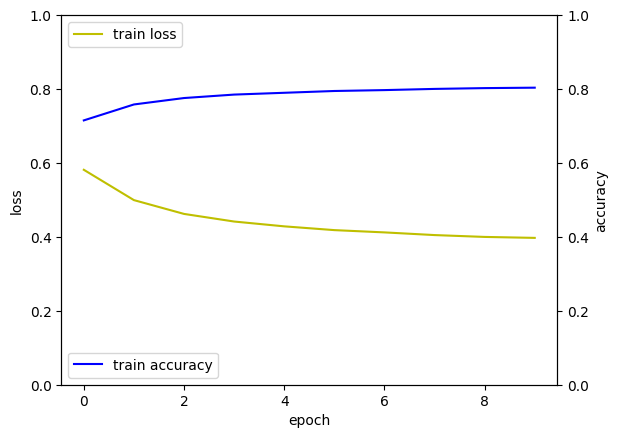

In [ ]:
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [ ]:
sub_preds_deep = model.predict(test_data_features,batch_size=32)

2187/2187 [==============================] - 5s 2ms/step


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
roc_auc = roc_auc_score(y_test_tensor, sub_preds_deep)
print("ROC-AUC DLM Score:", roc_auc)

ROC-AUC DLM Score: 0.7229689404138204


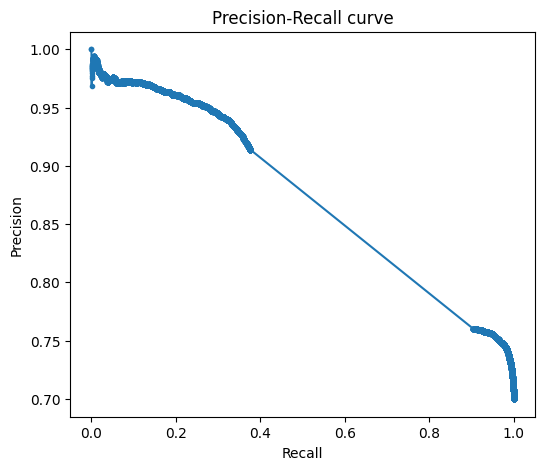

In [ ]:
# Calculate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_tensor, sub_preds_deep)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

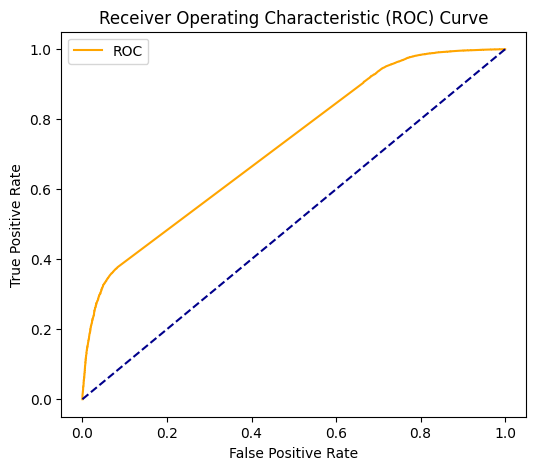

In [ ]:
# Calculate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_tensor, sub_preds_deep)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 3.2 Lightgbm Model

To improve the low accuracy, we will use machine learning. First of all, this is the sentiment analysis model using only usefulCount.

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

target = df_train['sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42)
feature_importance_df = pd.DataFrame()

clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )

clf.fit(trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric='logloss',
        )

sub_preds = clf.predict(df_test[feats])

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
solution = df_test['sentiment']
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[    0, 21009],
       [    0, 48969]])

We will add variables for higher accuracy.

In [ ]:
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

14265

In [ ]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [ ]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

100%|██████████| 212053/212053 [01:16<00:00, 2762.88it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889


In [ ]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])

array([[1.        , 0.25709864],
       [0.25709864, 1.        ]])

In [ ]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["sentiment"])

array([[1.        , 0.23518272],
       [0.23518272, 1.        ]])

In [ ]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 212053/212053 [02:23<00:00, 1478.82it/s]


In [ ]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

array([[1.        , 0.34831213],
       [0.34831213, 1.        ]])

In [ ]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["sentiment"])

array([[1.        , 0.31714515],
       [0.31714515, 1.        ]])

In [ ]:
df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count(unique
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))

#punctuation count
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

We added a season variable.

In [ ]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

We normalized useful count.

In [ ]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42)
feature_importance_df = pd.DataFrame()

clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )

clf.fit(trn_x, trn_y,
        eval_set= [(trn_x, trn_y), (val_x, val_y)],
    )

sub_preds = clf.predict(df_test[feats])

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[13970,  7039],
       [ 3673, 45296]])

In [ ]:
# Calculate ROC-AUC Score
roc_auc = roc_auc_score(solution, sub_preds)
print("ROC-AUC LightGBM Score:", roc_auc)

ROC-AUC LightGBM Score: 0.7949732392398192


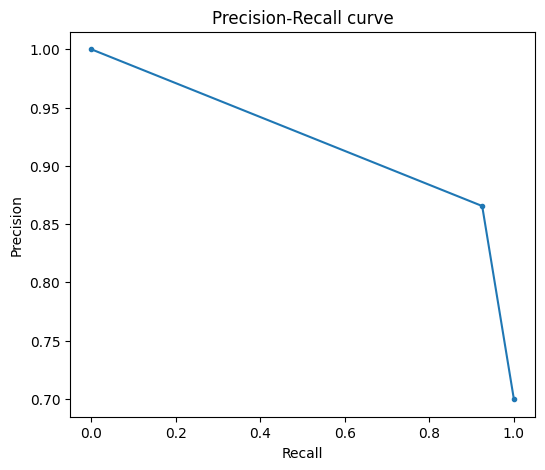

In [ ]:
# Calculate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(solution, sub_preds)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

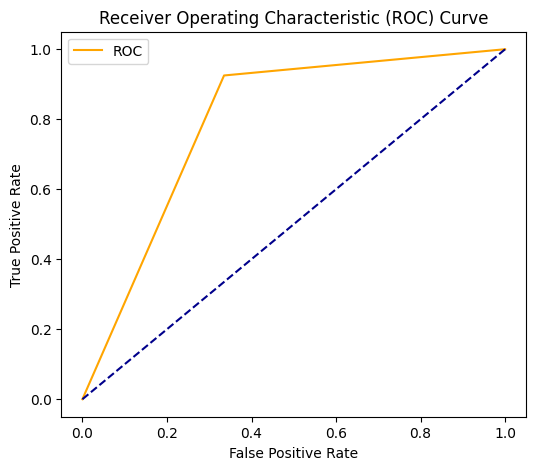

In [ ]:
# Calculate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(solution, sub_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

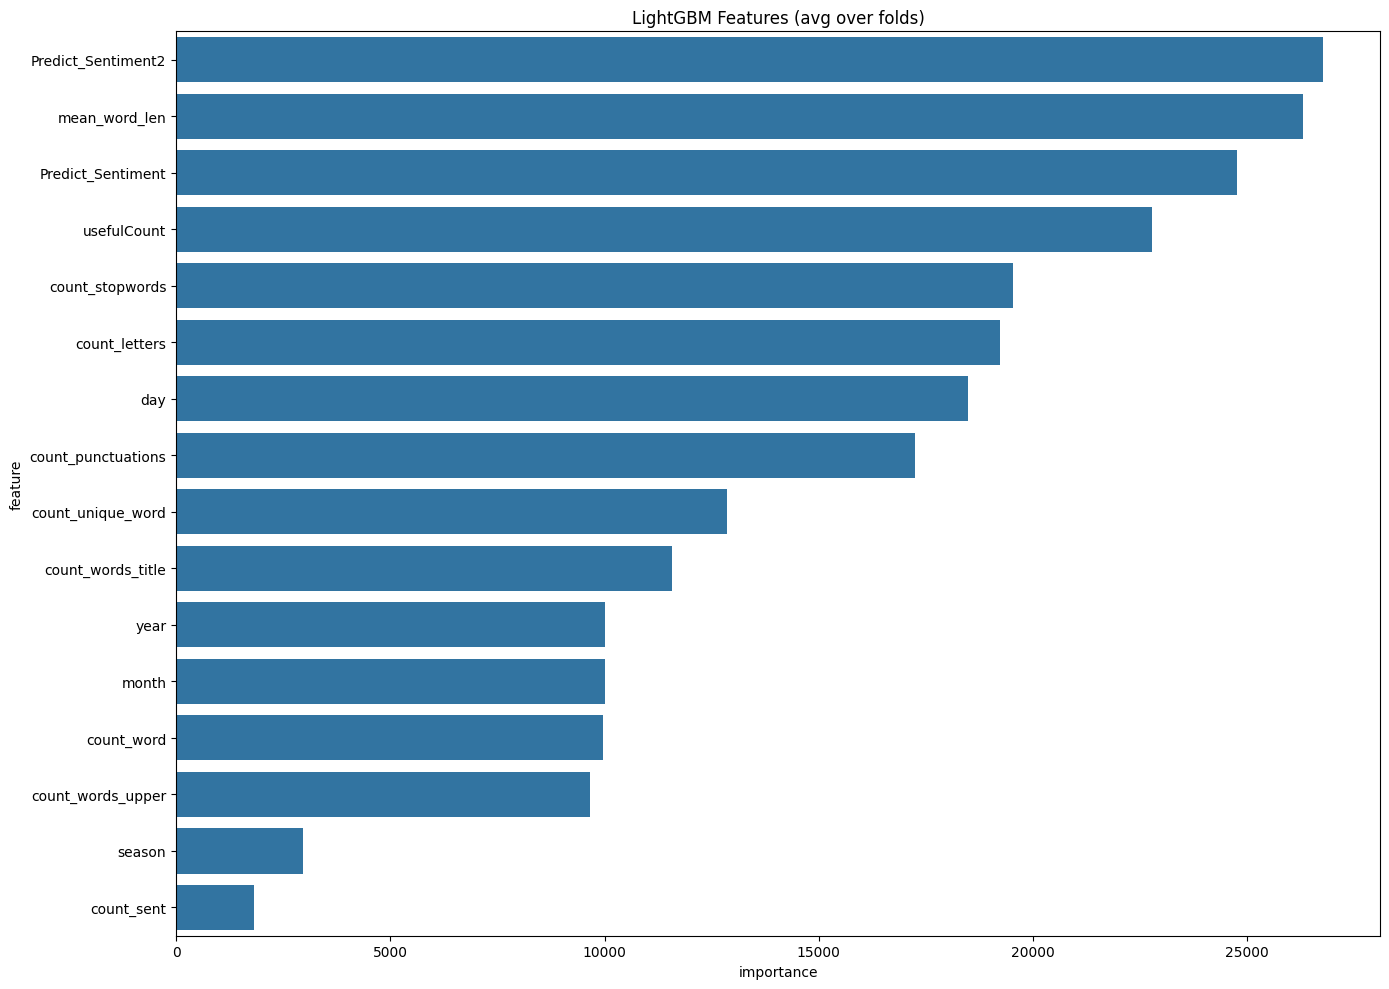

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')